In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist, fashion_mnist

import numpy as np
from matplotlib import pyplot as plt

# Blind source separation

This project aims to separate an image, formed as the sum of two images, into its original components.

The two source images, img1 and img2, are drawn from different datasets: MNIST and Fashion-MNIST, respectively.

No preprocessing is allowed. The neural network receives the combined image (img1 + img2) as input and outputs the predicted components (hat_img1,hat_img2).

Performance is evaluated using the mean squared error (MSE) between the predicted and ground-truth images.

Both datasets (MNIST and Fashion-MNIST) are grayscale. For simplicity, all samples are padded to a (32,32) resolution.

In [ ]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
print(np.shape(mnist_x_train))
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
#normnalize in and pad
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
print(np.shape(mnist_x_train))
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 32, 32)


In [ ]:
print(np.shape(mnist_x_train))

(60000, 32, 32)


Here is a simple datagenerator.

In [ ]:
def datagenerator(x1,x2,batchsize):
    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_data = (x1[num1] + x2[num2]) / 2.0
        y_data = (x1[num1], x2[num2])

        yield x_data, y_data

Let us define a generator with batchsize=1 and let's test it.

In [ ]:
onegen = datagenerator(mnist_x_test,fashion_mnist_x_test,1)

Let us look at some input-output pairs

In [ ]:
def show_images(x,y1,y2):
    fig, ax = plt.subplots(1,3,figsize=(12,4))
    ax[0].imshow(x,cmap='gray')
    ax[0].title.set_text('Input')
    ax[0].axis('off')
    ax[1].imshow(y1,cmap='gray')
    ax[1].title.set_text('mnist')
    ax[1].axis('off')
    ax[2].imshow(y2,cmap='gray')
    ax[2].title.set_text('fashion_mnist')
    ax[2].axis('off')
    plt.show()

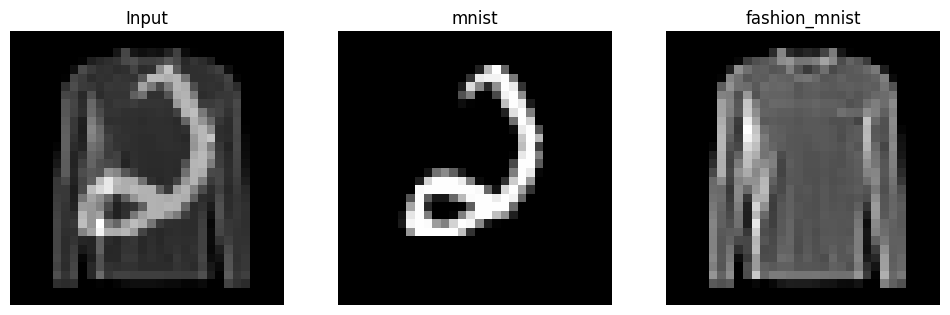

In [ ]:
x,(y1,y2)=next(onegen)
show_images(x[0],y1[0],y2[0])

# Model evalaution

Let us define the test generator.

In [ ]:
testgen = datagenerator(mnist_x_test,fashion_mnist_x_test,128)

eval_samples_x, (eval_samples_y1, eval_sample2) = next(testgen)

We test a model returning twice the input image. You will need to replace it with your own predictive model.

In [ ]:
def ide_model(x):
   return((x,x))

In [ ]:
def eval_model(model):
  x, (y1,y2) = next(testgen)

  # use model.predict to get predictions. Here we just call model
  pred1,pred2 = model(x)

  return (np.mean((pred1-y1)**2) + np.mean((pred2-y2)**2) / 2)

In [ ]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(ide_model))
print("mse = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

mse =  0.05558942408930197
standard deviation =  0.002147071057655818


# What to deliver
As usual, you are supposed to deliver a single notebook that is supposed to run on colab. The notebook should be adequately commented, contain a full trace of the training, the computation of the mse in the form specified above and a few examples.

Good Work!

#Solution

##Model Creation


To select the best model for this task, a few trials were performed. My initial choice was a simple encoder-decoder architecture, based on 2D Convolutional layers. This was a very light model (only 260,162 parameters). It didn't take long to train, and also gave out discrete results.

To obtain better results, I decided to go with a slightly more complex model: the **U-Net**. This model is particularly useful for tasks whose goal is to segment or reconstruct images.

First, a 4 layered U-Net was tested. It had 32 million parameters. Through this architecture, I was able to obtain better results. Since the images have very low resolution though, i thought that a simpler model would have been more suitable for the task. So i tried using a 3 layered U-Net (7,793,090 parameters). This architecture allowed me to achieve significant improvements over the two previous models.

In the convolutional blocks of the network, i decided to use **Batch Normalization** to normalize the activation of the Convolutional layers. This contributed to make the training process more stable.

Since the output expected is two (32,32) sized images, I used two parallel convolutional layers after the decoder structure.

The used optimizer is Adam, and the loss function is the mse, since our goal is to minimize this quantity.

In [2]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model

def build_unet():

    # convolutional block of U-Net
    def conv_block(x, filters, kernel_size=3, activation='relu', batch_norm=True):
        x = Conv2D(filters, (kernel_size, kernel_size), padding='same')(x)
        if batch_norm:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)
        x = Conv2D(filters, (kernel_size, kernel_size), padding='same')(x)
        if batch_norm:
            x = BatchNormalization()(x)
        x = Activation(activation)(x)
        return x

    # one of the blocks of the encoder
    def encoder_block(x, filters, pool_size=2):
        x = conv_block(x, filters)
        p = MaxPooling2D(pool_size=(pool_size, pool_size))(x)
        return x, p

    # one of the blocks of the decoder
    def decoder_block(x, skip, filters, kernel_size=3, activation='relu', batch_norm=True):
        x = UpSampling2D(size=(2, 2))(x)
        x = Concatenate()([x, skip])
        x = conv_block(x, filters, kernel_size=kernel_size, activation=activation, batch_norm=batch_norm)
        return x

    input_img = Input(shape=(32, 32, 1))

    # encoder
    s1, p1 = encoder_block(input_img, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)

    # bottleneck
    b = conv_block(p3, 512)

    # decoder
    d1 = decoder_block(b, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)

    # separate decoders for the two images
    output1 = Conv2D(1, (1, 1), activation='sigmoid', name="img1")(d3)
    output2 = Conv2D(1, (1, 1), activation='sigmoid', name="img2")(d3)

    model = Model(inputs=input_img, outputs=[output1, output2])
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_unet()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 16, 16, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 16, 16, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 8, 8, 128)      │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 256)      │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 7,793,090 (29.73 MB)

 Trainable params: 7,787,458 (29.71 MB)

 Non-trainable params: 5,632 (22.00 KB)

Here is a visual representation of my model using **visualkeras**.

In [ ]:
!pip install visualkeras -q

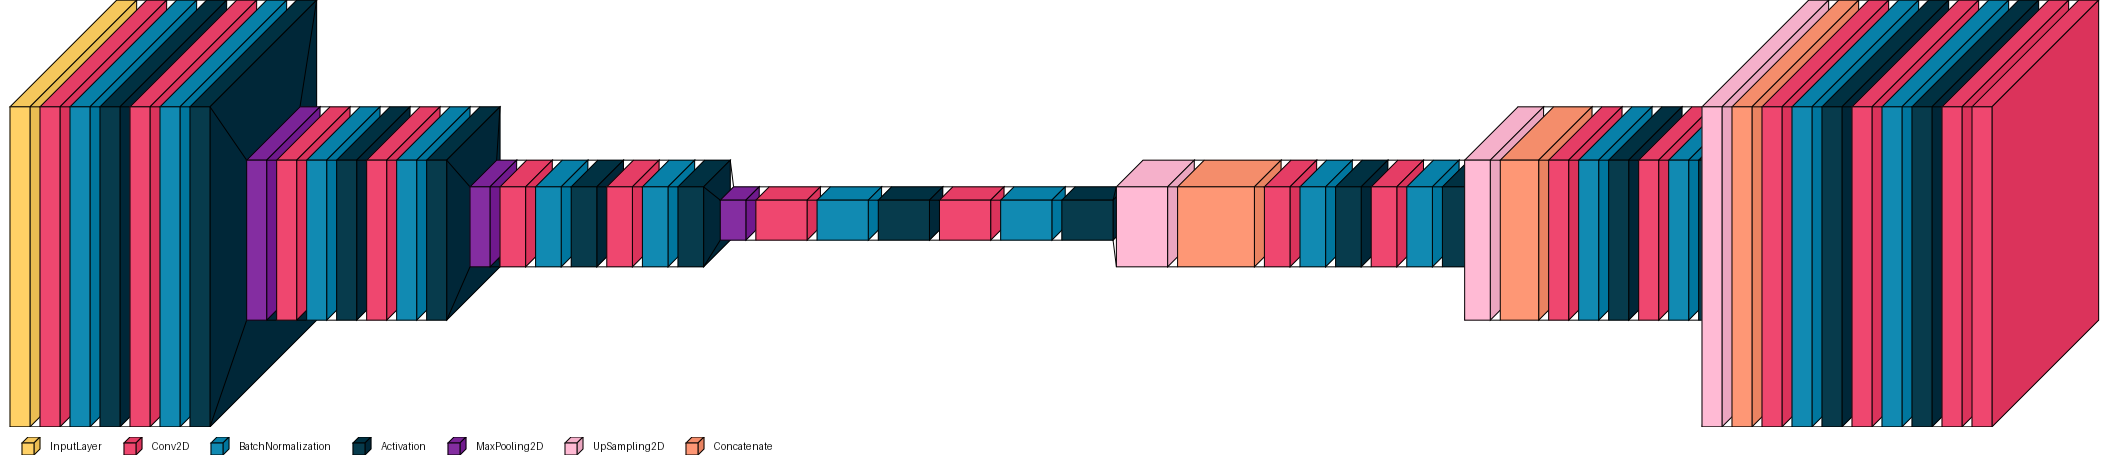

In [11]:
import visualkeras
visualkeras.layered_view(model, legend=True, scale_xy=10.0)

##Creating data generators

Here i'm using `train_test_split` from sklearn, to create a validation set from the given training set. The validation set will be used at training time, to check how the training process is going.

In [ ]:
from sklearn.model_selection import train_test_split

# splitting mnist_x_train into train set and validation set
mnist_x_train, mnist_x_val = train_test_split(mnist_x_train, test_size=0.2, random_state=42)

# splitting fashion_mnist_x_train into train set and validation set
fashion_mnist_x_train, fashion_mnist_x_val = train_test_split(fashion_mnist_x_train, test_size=0.2, random_state=42)

print("MNIST train shape:", mnist_x_train.shape)
print("MNIST val shape:", mnist_x_val.shape)
print("Fashion-MNIST train shape:", fashion_mnist_x_train.shape)
print("Fashion-MNIST val shape:", fashion_mnist_x_val.shape)


MNIST train shape: (48000, 32, 32)
MNIST val shape: (12000, 32, 32)
Fashion-MNIST train shape: (48000, 32, 32)
Fashion-MNIST val shape: (12000, 32, 32)


Creating three different generators from the given training, validation and test set.

In [ ]:
# generator for training
train_gen = datagenerator(mnist_x_train, fashion_mnist_x_train, batchsize=64)

# generator for validation
val_gen = datagenerator(mnist_x_val, fashion_mnist_x_val, batchsize=64)

# generator for testing
test_gen = datagenerator(mnist_x_test, fashion_mnist_x_test, batchsize=64)

##Training the model

Specifying the callback functions used at training time:
- **ModelCheckpoint**: used to save the weights of the model, obtained during the best epoch (according to the validation loss)
- **EarlyStopping**: stops training as soon a certain metric as stopped improving. In this case, we're monitoring the validation loss. Any improvement smaller than 0.000001 will be ignored, and the training will stop after 8 epochs with no improvement.
- **ReduceLROnPlateau**: used to reduce the Learning Rate once the validation loss stops decreasing. Having a dynamic learning rate allows further training of the model, even though the training process is stagnating.

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint_filepath = 'unet_simplified.weights.h5'

# callback to save model weigths
checkpoint = ModelCheckpoint(
                                filepath=checkpoint_filepath,
                                monitor='val_loss',
                                save_best_only=True,
                                save_weights_only=True,
                                mode='min',
                                verbose=0
                                )

# early stopping for training
early_stopping = EarlyStopping(monitor="val_loss", patience=8, verbose=1, min_delta=0.000001)

# learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.4, patience=4, min_delta=0.000001, verbose=1, mode="min")

In [ ]:
history = model.fit(train_gen, steps_per_epoch=1000, epochs=100, validation_data=val_gen, validation_steps=100, callbacks=[reduce_lr, early_stopping, checkpoint])


Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - img1_loss: 0.0166 - img2_loss: 0.0146 - loss: 0.0312 - val_img1_loss: 0.0031 - val_img2_loss: 0.0023 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - img1_loss: 0.0016 - img2_loss: 0.0019 - loss: 0.0034 - val_img1_loss: 0.0016 - val_img2_loss: 0.0024 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - img1_loss: 0.0012 - img2_loss: 0.0014 - loss: 0.0026 - val_img1_loss: 0.0010 - val_img2_loss: 0.0013 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - img1_loss: 0.0010 - img2_loss: 0.0012 - loss: 0.0022 - val_img1_loss: 8.9635e-04 - val_img2_loss: 9.5636e-04 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - img1_loss: 9.0067e-04 - img2_loss: 0.0011 - loss: 0.0020 - val_img1_loss: 8.0602e-04 - val_img2_loss: 8.7904e-04 - val_lo

##Model evaluation

For the evaluation of the model the given `eval_model()` function is used. The function remains unchanged, apart from the `np.squeeze()` function. Since the outputs of the last convolutional layers are three dimensional arrays, the said function removes the 'color channel' dimension, which for grayscale images is unused. Then it simply calculates the average mse between the two images.

In [ ]:
model_test = build_unet()
model_test.load_weights(checkpoint_filepath)

In [ ]:
def eval_model(model):
  x, (y1,y2) = next(test_gen)

  # use model.predict to get predictions. Here we just call model
  pred1,pred2 = model(x)

  # squeezing the predictions to remove the third dimension
  pred1 = np.squeeze(pred1)
  pred2 = np.squeeze(pred2)

  return (np.mean((pred1-y1)**2) + np.mean((pred2-y2)**2) / 2)

For a more accurate estimate of the performance of the model, `eval_model()` is run 10 times and the average evaluation is returned.

In [ ]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(model_test))
print("mse = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

mse =  0.000565271484555433
standard deviation =  7.064677912279944e-05


##Plotting the results

This section is dedicated to the plots. In the following cell a prediction using my model is performed. The results of the separation are then shown.

In [ ]:
x, (y1,y2) = next(testgen)

# predictions using data from testgen
pred1,pred2 = model_test(x)

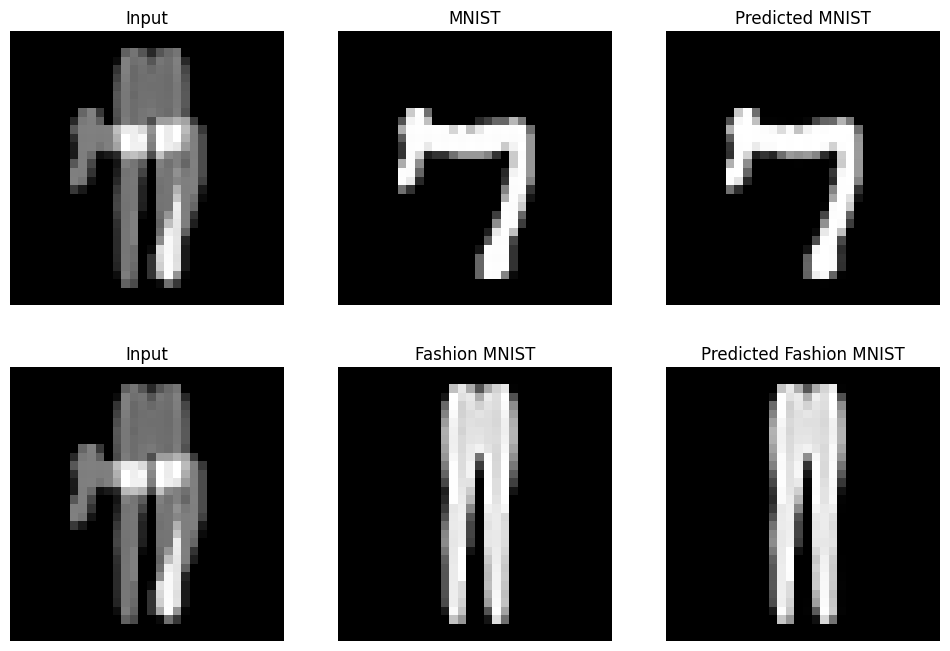

In [ ]:
# plotting pred1 and pred2
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax = ax.flatten()

ax[0].imshow(x[0], cmap='gray')
ax[0].title.set_text('Input')
ax[0].axis('off')

ax[1].imshow(y1[0], cmap='gray')
ax[1].title.set_text('MNIST')
ax[1].axis('off')

ax[2].imshow(pred1[0], cmap='gray')
ax[2].title.set_text('Predicted MNIST')
ax[2].axis('off')

ax[3].imshow(x[0], cmap='gray')
ax[3].title.set_text('Input')
ax[3].axis('off')

ax[4].imshow(y2[0], cmap='gray')
ax[4].title.set_text('Fashion MNIST')
ax[4].axis('off')

ax[5].imshow(pred2[0], cmap='gray')
ax[5].title.set_text('Predicted Fashion MNIST')
ax[5].axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.show()


Now I'm plotting the training loss and validation loss trend. As we can see, there's no evident sign of overfitting.

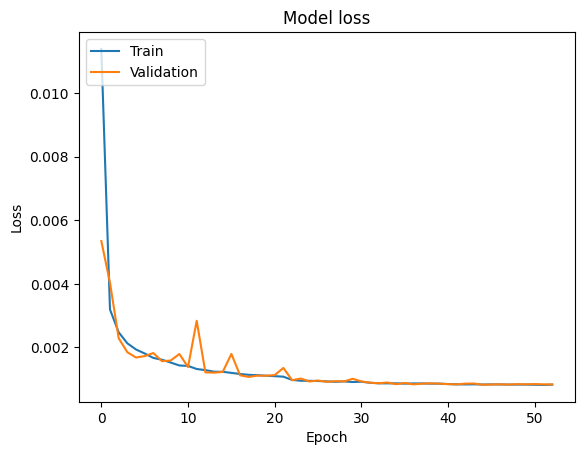

In [ ]:
# plotting training loss and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
